In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import os
import json

print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Tensorflow version: 2.4.1
Keras version: 2.4.0


In [2]:
with open('recipe1M_layers/layer1.json', 'r') as f:
    dataset = json.load(f)

In [3]:
dataset[0]

{'ingredients': [{'text': '6 ounces penne'},
  {'text': '2 cups Beechers Flagship Cheese Sauce (recipe follows)'},
  {'text': '1 ounce Cheddar, grated (1/4 cup)'},
  {'text': '1 ounce Gruyere cheese, grated (1/4 cup)'},
  {'text': '1/4 to 1/2 teaspoon chipotle chili powder (see Note)'},
  {'text': '1/4 cup (1/2 stick) unsalted butter'},
  {'text': '1/3 cup all-purpose flour'},
  {'text': '3 cups milk'},
  {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'},
  {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'},
  {'text': '1/2 teaspoon kosher salt'},
  {'text': '1/4 to 1/2 teaspoon chipotle chili powder'},
  {'text': '1/8 teaspoon garlic powder'},
  {'text': '(makes about 4 cups)'}],
 'url': 'http://www.epicurious.com/recipes/food/views/-world-s-best-mac-and-cheese-387747',
 'partition': 'train',
 'title': 'Worlds Best Mac and Cheese',
 'id': '000018c8a5',
 'instructions': [{'text': 'Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.'},


In [4]:
dataset_raw = []
for record in dataset:
    record_clean = {
        "title": record["title"],
        "ingredients": [ingredient["text"] for ingredient in record["ingredients"]],
        "instructions": "\n".join([instruction["text"] for instruction in record["instructions"]]),
        "id": record["id"],
        "partition": record["partition"]
    }
    dataset_raw.append(record_clean)

In [5]:
len(dataset_raw)

1029720

In [6]:
# Filters out recipes which don't have either title or ingredients or instructions or partition or id.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions', 'partition', 'id']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [7]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalid recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 1029720
Dataset size AFTER validation 1029720
Number of invalid recipes 0


In [8]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [9]:
# Converts recipe object to string (sequence of characters) for later usage in RNN input.
def recipe_to_string(recipe):
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [10]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  1029720


In [11]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Worlds Best Mac and Cheese

🥕

• 6 ounces penne
• 2 cups Beechers Flagship Cheese Sauce (recipe follows)
• 1 ounce Cheddar, grated (1/4 cup)
• 1 ounce Gruyere cheese, grated (1/4 cup)
• 1/4 to 1/2 teaspoon chipotle chili powder (see Note)
• 1/4 cup (1/2 stick) unsalted butter
• 1/3 cup all-purpose flour
• 3 cups milk
• 14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)
• 2 ounces semisoft cheese (page 23), grated (1/2 cup)
• 1/2 teaspoon kosher salt
• 1/4 to 1/2 teaspoon chipotle chili powder
• 1/8 teaspoon garlic powder
• (makes about 4 cups)

📝

▪︎ Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.
▪︎ Cook the penne 2 minutes less than package directions.
▪︎ (It will finish cooking in the oven.)
▪︎ Rinse the pasta in cold water and set aside.
▪︎ Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly.
▪︎ Scrape the pasta into the prepared baking dish.
▪︎ Sprinkle the top with the cheeses and then the chil

In [12]:
print(dataset_stringified[50000])

📗 Cashew Chicken

🥕

• 14 cup tapioca flour
• 12 teaspoon pepper
• 6 tablespoons coconut aminos or 6 tablespoons low sodium soy sauce
• 2 lbs chicken breasts (cut into 1.5-inch pieces) or 2 lbs chicken thighs (cut into 1.5-inch pieces)
• 4 tablespoons rice wine vinegar
• 4 tablespoons organic ketchup
• 12 teaspoon powdered ginger or 1 teaspoon fresh ginger
• 1 -2 tablespoon organic sugar
• 2 garlic cloves, minced
• 12 teaspoon red pepper flakes (optional)
• 2 carrots, sliced thin
• 2 stalks celery, sliced thin
• 1 medium zucchini, chopped
• 3 -4 green onions, sliced
• 2 -3 tablespoons coconut oil, divided
• 1 cup raw cashews

📝

▪︎ Melt 1.5 Tbs of the oil in a large skillet and saute all the veggies until almost soft; remove to a plate.
▪︎ Melt the remaining coconut oil in the skillet.
▪︎ Meanwhile, combine the tapioca flour and the pepper in a large Ziplock bag.
▪︎ Add chicken and shake to cover all pieces.
▪︎ Cook the chicken in the hot oil, over medium high heat, stirring often, unt

In [13]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

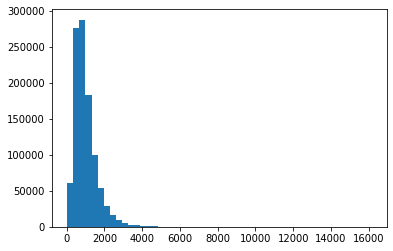

In [14]:
plt.hist(recipes_lengths, bins=50)
plt.show()

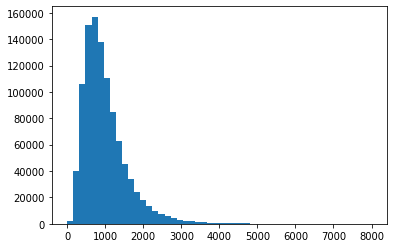

In [15]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [16]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 2000

In [17]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [18]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  1029720
Dataset size AFTER filtering:  965383
Number of etiminated recipes:  64337


In [19]:
dataset_filtered = dataset_filtered[:10000]

In [20]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  10000


In [21]:
# Indicator of the end of the recipe.
STOP_SIGN = '␣'

In [22]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [23]:
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

In [24]:
tokenizer.fit_on_texts(dataset_filtered)

In [25]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 10001,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 10000, " ": 1469133, "D": 6334, "i": 415401, "l": 314028, "y": 62725, "M": 9119, "a": 499162, "c": 248214, "r": 400219, "o": 506824, "n": 441931, "S": 26296, "d": 257952, "R": 10313, "e": 761554, "p": 223858, "\\n": 252687, "\\ud83e\\udd55": 10000, "\\u2022": 88623, "1": 81614, ".": 99096, "b": 117364, "w": 80820, "m": 151088, "u": 227009, "A": 14584, "h": 229155, "s": 393582, "(": 17532, "4": 21506, ")": 17589, "/": 19238, "2": 46624, "g": 142995, "3": 20410, "t": 483090, "v": 58854, "\\ud83d\\udcdd": 10000, "\\u25aa": 94064, "\\ufe0e": 94064, "C": 23170, "k": 79125, ";": 6084, ",": 80619, "B": 14238, "x": 20215, "T": 12856, "f": 94457, "6": 4807, "G": 5163, "z": 10934, "8": 5613, "q": 5560, "K": 1864, "E": 4035, "-": 18782, "O": 5368, "P": 17673, "F": 9142, "5": 13657, "0": 15799, "H": 4560, "j": 9200, 

In [26]:
# Adding +1 to take into account a special unassigned 0 index.
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  102


In [27]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

t
.


In [28]:
tokenizer.word_index['r']

8

In [29]:
# For demo application we need to have an array of characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'o', 'a', 't', 'n', 'i', 'r', 's', 'l', 'd', '\n', 'c', 'h', 'u', 'p', 'm', 'g', 'b', '.', 'f', '▪', '︎', '•', '1', 'w', ',', 'k', 'y', 'v', '2', 'S', 'C', '4', '3', 'x', '/', '-', 'P', ')', '(', '0', 'A', 'B', '5', 'T', 'z', 'R', '📗', '🥕', '📝', 'I', 'j', 'F', 'M', 'D', ';', 'W', 'L', '8', 'q', 'O', 'G', '6', 'H', 'E', "'", 'N', ':', '9', '7', 'K', 'U', 'V', '!', 'Y', '&', '"', 'J', '*', 'Q', 'Z', '$', '%', 'X', '[', ']', '#', '?', '~', '+', '@', '=', '>', '`', '{', '}', '_', '^', '␣', '\\']


In [31]:
# Test proper conversion from text to indices.
# This is needed for debugging a demo app.
tokenizer.texts_to_sequences(['📗 yes'])

[[49, 1, 29, 2, 9]]

In [32]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [33]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [34]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 10000


In [35]:
print(dataset_vectorized[0][:10], '...')

[49, 1, 56, 7, 10, 10, 29, 1, 55, 4] ...


In [36]:
max_index_example = np.max(dataset_vectorized)

print('max_index_example: ', max_index_example)

max_index_example:  [49, 1, 96, 44, 2, 7, 53, 7, 6, 14, 3, 9, 1, 56, 2, 1, 33, 3, 13, 3, 97, 1, 44, 8, 4, 47, 7, 10, 7, 4, 6, 1, 33, 3, 13, 3, 6, 15, 5, 1, 46, 8, 2, 4, 5, 9, 12, 12, 50, 12, 12, 24, 1, 25, 1, 41, 35, 70, 71, 1, 18, 40, 1, 13, 4, 6, 1, 13, 3, 6, 11, 2, 6, 9, 2, 11, 1, 17, 7, 10, 28, 12, 24, 1, 25, 42, 42, 1, 18, 1, 13, 3, 13, 3, 6, 15, 5, 1, 21, 10, 4, 28, 2, 9, 27, 1, 16, 10, 15, 9, 1, 2, 36, 5, 8, 4, 1, 21, 3, 8, 1, 8, 3, 10, 10, 7, 6, 18, 12, 24, 1, 25, 1, 5, 4, 19, 10, 2, 9, 16, 3, 3, 6, 1, 19, 15, 5, 5, 2, 8, 27, 1, 16, 10, 15, 9, 1, 2, 36, 5, 8, 4, 1, 21, 3, 8, 1, 8, 3, 10, 10, 7, 6, 18, 12, 24, 1, 25, 64, 1, 13, 10, 3, 30, 2, 9, 27, 1, 21, 3, 8, 1, 11, 2, 13, 3, 8, 4, 5, 7, 6, 18, 12, 12, 51, 12, 12, 22, 23, 1, 52, 6, 1, 4, 1, 16, 4, 6, 1, 4, 11, 11, 1, 5, 14, 2, 1, 13, 3, 6, 11, 2, 6, 9, 2, 11, 1, 17, 7, 10, 28, 27, 1, 25, 42, 42, 18, 1, 3, 21, 1, 13, 3, 13, 3, 6, 15, 5, 1, 21, 10, 4, 28, 2, 9, 1, 4, 6, 11, 1, 5, 14, 2, 1, 19, 15, 5, 5, 2, 8, 20, 12, 22, 23, 1, 

/home/nenad/faks/SIAP/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [37]:
recipe_sequence_to_string(dataset_vectorized[0])

📗 Dilly Macaroni Salad Recipe

🥕

• 1 c. elbow macaroni
• 1 c. cubed American cheese (4 ounce.)
• 1/2 c. sliced celery
• 1/2 c. minced green pepper
• 3 tbsp. minced pimento
• 1/2 c. mayonnaise or possibly salad dressing
• 1 tbsp. vinegar
• 3/4 teaspoon salt
• 1/2 teaspoon dry dill weed

📝

▪︎ Cook macaroni according to package directions; drain well.
▪︎ Cold.
▪︎ Combine macaroni, cheese cubes, celery, green pepper and pimento.
▪︎ Blend together mayonnaise or possibly salad dressing, vinegar, salt and dill weed; add in to macaroni mix.
▪︎ Toss lightly.
▪︎ Cover and refrigeratewell.
▪︎ Serve salad in lettuce lined bowl if you like.
▪︎ Makes 6 servings.



In [38]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 659
Recipe #2 length: 600
Recipe #3 length: 654
Recipe #4 length: 389
Recipe #5 length: 1008
Recipe #6 length: 443
Recipe #7 length: 423
Recipe #8 length: 197
Recipe #9 length: 499
Recipe #10 length: 1788


In [39]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [40]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [41]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [42]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 Dilly Macaroni Salad Recipe

🥕

• 1 c. elbow macaroni
• 1 c. cubed American cheese (4 ounce.)
• 1/2 c. sliced celery
• 1/2 c. minced green pepper
• 3 tbsp. minced pimento
• 1/2 c. mayonnaise or possibly salad dressing
• 1 tbsp. vinegar
• 3/4 teaspoon salt
• 1/2 teaspoon dry dill weed

📝

▪︎ Cook macaroni according to package directions; drain well.
▪︎ Cold.
▪︎ Combine macaroni, cheese cubes, celery, green pepper and pimento.
▪︎ Blend together mayonnaise or possibly salad dressing, vinegar, salt and dill weed; add in to macaroni mix.
▪︎ Toss lightly.
▪︎ Cover and refrigeratewell.
▪︎ Serve salad in lettuce lined bowl if you like.
▪︎ Makes 6 servings.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [43]:
max_index_example = np.max(dataset_vectorized_padded)

print('max_index_example: ', max_index_example)

max_index_example:  101


In [44]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (2001,), types: tf.int32>


In [45]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 49   1  56 ... 100 100 100] 



Stringified recipe:

📗 Dilly Macaroni Salad Recipe

🥕

• 1 c. elbow macaroni
• 1 c. cubed American cheese (4 ounce.)
• 1/2 c. sliced celery
• 1/2 c. minced green pepper
• 3 tbsp. minced pimento
• 1/2 c. mayonnaise or possibly salad dressing
• 1 tbsp. vinegar
• 3/4 teaspoon salt
• 1/2 teaspoon dry dill weed

📝

▪︎ Cook macaroni according to package directions; drain well.
▪︎ Cold.
▪︎ Combine macaroni, cheese cubes, celery, green pepper and pimento.
▪︎ Blend together mayonnaise or possibly salad dressing, vinegar, salt and dill weed; add in to macaroni mix.
▪︎ Toss lightly.
▪︎ Cover and refrigeratewell.
▪︎ Serve salad in lettuce lined bowl if you like.
▪︎ Makes 6 servings.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [46]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [47]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [48]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   D i l l y   M a c a r o n i   S a l a d   R e c i p e \n \n 🥕 \n \n •   1   c .   e l b o w   m a c'
Target:  '  D i l l y   M a c a r o n i   S a l a d   R e c i p e \n \n 🥕 \n \n •   1   c .   e l b o w   m a c a'


In [49]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 49 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 56 ('D')
Step  3
  input: 56 ('D')
  expected output: 7 ('i')
Step  4
  input: 7 ('i')
  expected output: 10 ('l')
Step  5
  input: 10 ('l')
  expected output: 10 ('l')
Step  6
  input: 10 ('l')
  expected output: 29 ('y')
Step  7
  input: 29 ('y')
  expected output: 1 (' ')
Step  8
  input: 1 (' ')
  expected output: 55 ('M')
Step  9
  input: 55 ('M')
  expected output: 4 ('a')
Step 10
  input: 4 ('a')
  expected output: 13 ('c')


In [50]:
print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [51]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  10000
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  102


In [53]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

In [54]:
dataset_train = dataset_targeted \
  .shuffle(SHUFFLE_BUFFER_SIZE) \
  .batch(BATCH_SIZE, drop_remainder=True) \
  .repeat()

print(dataset_train)

<RepeatDataset shapes: ((64, 2000), (64, 2000)), types: (tf.int32, tf.int32)>


In [55]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 49   1  32 ... 100 100 100]
 [ 49   1  43 ... 100 100 100]
 [ 49   1  33 ... 100 100 100]
 ...
 [ 49   1  39 ... 100 100 100]
 [ 49   1   9 ... 100 100 100]
 [ 49   1  62 ... 100 100 100]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  32  15 ... 100 100 100]
 [  1  43  10 ... 100 100 100]
 [  1  33   3 ... 100 100 100]
 ...
 [  1  39   4 ... 100 100 100]
 [  1   9   2 ... 100 100 100]
 [  1  62   8 ... 100 100 100]], shape=(64, 2000), dtype=int32)


In [56]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[2 5 0 1 1 5 0 9]
 [4 1 5 5 8 3 9 4]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.03935884 -0.02856649  0.03949095  0.01182967  0.00201129]
  [ 0.01034914 -0.03823736  0.0057352   0.02447255  0.02012812]
  [-0.00740807  0.01597485 -0.01953821 -0.04140968  0.04290983]
  [ 0.02257681  0.04394804  0.01836641 -0.02136711  0.04009095]
  [ 0.02257681  0.04394804  0.01836641 -0.02136711  0.04009095]
  [ 0.01034914 -0.03823736  0.0057352   0.02447255  0.02012812]
  [-0.00740807  0.01597485 -0.01953821 -0.04140968  0.04290983]
  [-0.04128193 -0.01630398  0.0393586  -0.03839464  0.02939672]]

 [[-0.00010477 -0.02054576  0.02029934  0.03907696 -0.02464532]
  [ 0.02257681  0.04394804  0.01836641 -0.02136711  0.04009095]
  [ 0.01034914 -0.03823736  0.0057352   0.02447255  0.02012812]
  [ 0.01034914 -0.03823736  0.0057352   0.02447255  0.02012812]
  [-0.02263125 -0.01996081  0.02445222  0.00480532 -0.00691847]
  [ 0.01076756  0.01211058 

In [57]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [58]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [59]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           26112     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 102)           104550    
Total params: 5,377,638
Trainable params: 5,377,638
Non-trainable params: 0
_________________________________________________________________


In [61]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 102) # (batch_size, sequence_length, vocab_size)


In [62]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 4.4282683e-04 -1.8786700e-03  1.6066602e-03  6.6993264e-03
  2.9222865e-04  3.9959676e-03  9.6368417e-03  1.5699025e-03
  4.2908238e-03  1.1954735e-03  2.8902437e-03 -1.4440452e-03
  3.2361040e-03  6.0781522e-04  1.0570972e-03 -4.5267330e-03
 -6.4871153e-03 -6.0083661e-03  1.7645801e-03  5.5293255e-03
 -4.7595273e-03  9.9675287e-04  1.8931022e-03  5.0927227e-04
 -7.2629564e-03 -8.3387445e-04  3.5099844e-03  5.5061225e-03
  4.5769275e-03  3.2508723e-04 -4.0296116e-03 -5.0898612e-04
 -1.7637792e-03 -4.6178214e-03 -1.6380239e-03  2.2367893e-04
  4.7997851e-03 -4.7538616e-03 -3.2069571e-03 -7.5746793e-04
 -5.8040796e-03  6.5190056e-03 -8.2996329e-03 -1.0872615e-03
  4.3292101e-03  6.5282569e-05  8.1932433e-03  6.6309521e-04
  3.1817879e-03  6.0632988e-03  1.9224128e-04 -8.8535435e-04
  6.2244027e-03  5.1239529e-04  1.2197646e-03  1.6033433e-03
  2.2098075e-03  3.7731442e-03 -5.2443929e-03 -3.9289459e-03
  2.4653403e-03 -

In [63]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 1 2 2 1]], shape=(1, 5), dtype=int64)


In [64]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([2000, 1])

In [65]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [66]:
sampled_indices[:100]

array([  5,  87,  10,  32,  32,  19,  42,  29,  14,  70,  39,  60,  28,
        10,  48,  31,  51,   3,  66,  24,  24,  53,  71,  36,  42,  90,
         5,  33,  62,   8,  16,  96,  53,  42,  13,  98,  51, 100,  24,
        99,  13,  38,  51,  19,  73,  95,  80,  28,  61,   6,  27,  92,
        49,  17,  72,  85,  39,  36,  28,  27,  36,  74,  10,  40,  57,
        22,  68,  10,  70,   2, 100,  51,  40,  63,  62,  51,  51,  93,
        34,  67,  55,  33,   2,   4,  99,  80,  35,  14,  45,  17,  31,
        28,  55,  33,  33,  71,  28,  50,  26,  14])

In [67]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   B r u s s e l s   S p r o u t s   a l a   A n g e l a \n \n 🥕 \n \n •   6   s l i c e s   b a c o n'

Next char prediction:
 't ] l S S b 0 y h 9 P 8 k l R 2 📝 o E • • j 7 x 0 ~ t C O r p { j 0 c _ 📝 ␣ • ^ c - 📝 b U ` * k q n'


In [68]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 102) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

In [69]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 102)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       4.627686


In [70]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [71]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [72]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [73]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [74]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [75]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

In [ ]:
# Unzip uploaded checkpoint to checkpoints folder if needed
# unzip_checkpoint('ckpt_10.zip')

In [ ]:
# Loading the latest training data from checkpoints if needed.
# model_1 = model_weights_from_latest_checkpoint(model_1)

In [ ]:
# Loading weights from H5 file if needed.
# model_1.load_weights('recipe_generation_rnn_batch_64.h5')

In [76]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [77]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [78]:
INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
EPOCHS_DELTA = 1
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 1500

print('\n')
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

Latest checkpoint was not found. Starting from epoch #0


INITIAL_EPOCH:    0
EPOCHS_DELTA:     1
EPOCHS:           1
STEPS_PER_EPOCH:  1500


In [1]:
history_1 = {}
# history_1 = {} if not history_1 else history_1
print(history_1)

{}


In [ ]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.h5'
model_1.save(model_name, save_format='h5')

download_latest_checkpoint(zip_only=True)

In [ ]:
print(history_1)

In [ ]:
# Download zipped latest checkpoint to local drive.
# download_latest_checkpoint(zip_only=True)

In [ ]:
# model_name = 'recipe_generation_rnn_raw_' + INITIAL_EPOCH + '.h5'
# model_1.save(model_name, save_format='h5')

In [ ]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

In [ ]:
render_training_history(history_1)

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [ ]:
model_1_simplified.summary()

In [ ]:
model_1_simplified.input_shape

In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')


In [ ]:
generate_combinations(model_1_simplified)

In [ ]:
model_name = 'recipe_generation_rnn.h5'
model_1_simplified.save(model_name, save_format='h5')